<h1>Salience Function Metrics</h1>

This notebook shows how to compute the salience function metrics described in:

* [1] J. Salamon, E. Gómez, and J. Bonada. Sinusoid extraction and salience function design for predominant melody estimation. In 14th Int. Conf. on Digital Audio Effects (DAFx-11), pages 73–80, Paris, France, Sep. 2011.

The code is specifically written for evaluating the salience function returned by [Melodia](mtg.upf.edu/technologies/melodia) [2] or [Durrieu](https://github.com/wslihgt/IMMF0salience) [3], but could be adapted relatively easily to other salience functions.

If you use code from this notebook, it would be awesome if you cited [1]. Thanks!

For questions please contact me at: justin.salamon@nyu.edu

[2] J. Salamon and E. Gómez. Melody extraction from polyphonic music signals using pitch contour charac- teristics. IEEE Transactions on Audio, Speech, and Language Processing, 20(6):1759–1770, Aug. 2012.

[3] J.-L. Durrieu, B. David, and G. Richard. A musically motivated mid-level representation for pitch estimation and musical audio source separation. IEEE Journal on Selected Topics on Signal Processing, 5(6):1180–1191, Oct. 2011.

In [1]:
# The usual imports :)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mir_eval
from scipy.signal import find_peaks_cwt
from scipy.stats import ks_2samp
%matplotlib inline

In [2]:
# Functions to convert from salience function bin to frequency (in Hz) and back.
# In our case, both the Melodia and Durrieu functions start at 55 Hz (bin 0) and 
# were computed with a resolution of 10 bins per semitone (10 center per bin).

def salbin2freq(bin):    
    return 2**(bin/120.) * 55

def freq2salbin(freq):
    return 120*np.log2(freq/55.)

In [3]:
# Main function to compute the metrics for 1 excerpt
def compute_salience_metrics(salience_file, gt_file, saltype='melodia'):
    """
    Parameters
    ----------
    salience_file : str
        Path to salience function data file. First column in file must be timestamps.
    gt_file: str
        Path to ground truth file. First column is timestamps, second is frequency in Hz.
    saltype : str
        'melodia' or 'durrieu'

    Returns
    -------
    dfs : list of float
        Per-frame df scores
    rrs : list of float
        Per-frame reciprocal rank scores
    s1s : list of float
        Per-frames S1 scores
    s3s : list of float
        Per-frame S3 scores
    
    """
    
    # Setup
    if saltype=='melodia':
        sal_sep = ','
        gt_sep = '\t'
    elif saltype=='durrieu':
        sal_sep = r"\s*"
        gt_sep = '\t'
    
    # Load salience and ground truth
    salience = pd.read_csv(salience_file, header=None, sep=sal_sep, engine='python')
    gt = pd.read_csv(gtfile, header=None, sep=gt_sep)
    
    # Convert ground truth to same time resolution as salience function
    sal_timebase = salience.values[:,0]
    sal = salience.values[:,1:]
    gt_sal_freq, gt_sal_voicing = mir_eval.melody.resample_melody_series(
        gt.values[:,0], gt.values[:,1], gt.values[:,1]>0, sal_timebase)
    
    # Initialize score lists
    dfs = []
    rrs = []
    s1s = []
    s3s = []
    
    for n, frame in enumerate(sal):
            
        # Metrics are only computed for frames where the melody is present!
        if gt_sal_freq[n] > 0:
            
            # Get all salience peak locations and values
            plocs = find_peaks_cwt(frame, np.arange(3,10))
            pvals = frame[plocs]
            
            # Must be at least 1 salience peak to compute metrics for the frame
            if len(plocs) > 0:

                # Find melody peak (closest to gt freq)
                diffs = np.abs(np.asarray(plocs) - freq2salbin(gt_sal_freq[n]))
                closest_bin = plocs[np.argmin(diffs)]
                closest_freq = salbin2freq(closest_bin)

                # Compute freq distance in cents
                dfs.append(np.abs(1200*np.log2(closest_freq/gt_sal_freq[n])))

                # Compute reciprocal rank
                closest_val = frame[closest_bin]
                order = np.argsort(pvals)
                pvals_sorted = pvals[order]
                rank = len(pvals) - np.where(pvals_sorted==closest_val)[0][0]
                rr = 1/float(rank)
                rrs.append(rr)

                # Compute S1 and S3
                s1 = closest_val / np.max(pvals)
                if len(pvals_sorted) >= 3:
                    s3 = closest_val / np.mean(pvals_sorted[-3:])
                else:
                    s3 = closest_val / np.mean(pvals_sorted)
                s1s.append(s1)
                s3s.append(s3)

    return dfs, rrs, s1s, s3s

<h2>Example Use</h2>

In [4]:
# Define path to Melodia and Durrieu salience functions and correpsonding ground truth file
melodiafile = ('/Users/justin/datasets/saliencefunctions/sample/melodia-salience/'
               'Beethoven-S3-I-ex1_vamp_melodia-salience_melodia-salience_saliencefunction.csv')
durrieufile = '/Users/justin/datasets/saliencefunctions/sample/durrieu-salience/Beethoven-S3-I-ex1.Msal'
gtfile = '/Users/justin/datasets/saliencefunctions/sample/GT/Beethoven-S3-I-ex1.mel'

In [5]:
Mdfs, Mrrs, Ms1s, Ms3s = compute_salience_metrics(melodiafile, gtfile, saltype='melodia')

In [6]:
Ddfs, Drrs, Ds1s, Ds3s = compute_salience_metrics(durrieufile, gtfile, saltype='durrieu')

Let's compare the results on this excerpt for the two salience functions:

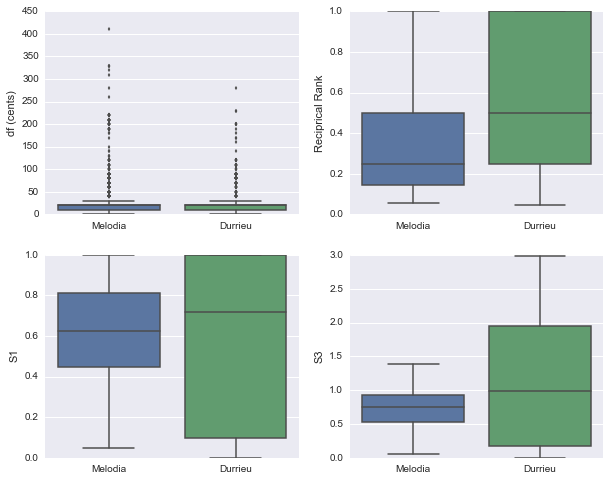

In [7]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(221)
sns.boxplot([Mdfs, Ddfs], )
ax.set_xticklabels(['Melodia', 'Durrieu'])
plt.ylabel('df (cents)')

ax = fig.add_subplot(222)
sns.boxplot([Mrrs, Drrs], )
ax.set_xticklabels(['Melodia', 'Durrieu'])
plt.ylabel('Reciprical Rank')

ax = fig.add_subplot(223)
sns.boxplot([Ms1s, Ds1s], )
ax.set_xticklabels(['Melodia', 'Durrieu'])
plt.ylabel('S1')

ax = fig.add_subplot(224)
sns.boxplot([Ms3s, Ds3s], )
ax.set_xticklabels(['Melodia', 'Durrieu'])
plt.ylabel('S3')

plt.show()

Note that if you are evaluating on a dataset of multiple songs/excerpts, rather than comparing the results on a per-excerpt basis like above, it makes more sense to affregate all the results for evaluation.